In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    GradientBoostingClassifier,
    AdaBoostClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest, mutual_info_classif

c:\users\sed\anaconda3\envs\comp47750\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\sed\anaconda3\envs\comp47750\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\sed\anaconda3\envs\comp47750\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


<IPython.core.display.Javascript object>

# Part 1 Rectifying Bias

In [3]:
surv = pd.read_csv("survival.csv")
surv["Survived"] = "GE5"
surv.loc[surv["Class"] == 2, "Survived"] = "L5"
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


<IPython.core.display.Javascript object>

In [4]:
surv["Survived"].value_counts()

GE5    225
L5      81
Name: Survived, dtype: int64

<IPython.core.display.Javascript object>

In [5]:
y = surv.pop("Survived").values
surv.pop("Class")
ap_features = surv.columns
X = surv.values
X.shape, y.shape

((306, 3), (306,))

<IPython.core.display.Javascript object>

## 1.1 Hold-Out Evalauation of Rectifying Strategy
In the below section Hold out testing will be conducted on the imbalanced data utilising the rectifying strategy of SMOTE. To ensure that a broad range of results are attained with differnt random sample it will be run 100 times. Each time the data will be split into train test and the training data will then be Upsampled using the SMOTE Technique. The Resampled data will then be used to train and predict the X_test data.

In [6]:
reps = 100


def hold_out_resample(X, y, model, resample, reps=100):
    ho_ba = []
    ho_acc = []
    f1_true = []
    f1_neg = []
    precision_true = []
    precision_neg = []
    recall_true = []
    recall_neg = []
    for i in range(reps):
        # Train test split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)

        # Resample the training data
        X_resampled_nm1, y_resampled_nm1 = resample.fit_resample(X_train, y_train)

        # Train using resampled data and Predict using the original test data
        y_pred = model.fit(X_resampled_nm1, y_resampled_nm1).predict(X_test)

        # Obtain Balanced Accuracy
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        ho_ba.append(bal_acc)

        # Obtain Accuracy
        acc = accuracy_score(y_test, y_pred)
        ho_acc.append(acc)

        # Obtain Precision
        pr_t = precision_score(y_test, y_pred, pos_label="L5", average="binary")
        precision_true.append(pr_t)

        pr_n = precision_score(y_test, y_pred, pos_label="GE5", average="binary")
        recall_neg.append(pr_n)

        # Obtain Recall
        rec_t = recall_score(y_test, y_pred, pos_label="L5", average="binary")
        recall_true.append(rec_t)

        rec_n = recall_score(y_test, y_pred, pos_label="GE5", average="binary")
        precision_neg.append(rec_n)

        # Obtain f1-score
        f1_t = f1_score(y_test, y_pred, pos_label="L5", average="binary")
        f1_true.append(f1_t)

        f1_n = f1_score(y_test, y_pred, pos_label="GE5", average="binary")
        f1_neg.append(f1_n)

    # Print out the Mean statistics
    print(f"========= Statistics for {model.__class__.__name__} =========")
    print("Mean Hold Out Accuracy: %0.2f " % (sum(ho_acc) / reps))
    print("Mean Hold Out Balanced Accuracy: %0.2f " % (sum(ho_ba) / reps))
    print("-------------------------------------------------------")

    print("Mean Hold Out f1-score Positive: %0.2f " % (sum(f1_true) / reps))
    print("Mean Hold Out f1-score Negative: %0.2f " % (sum(f1_neg) / reps))

    print("-------------------------------------------------------")
    print("Mean Hold Out Precision Positive: %0.2f " % (sum(precision_true) / reps))
    print("Mean Hold Out Precision Negative: %0.2f " % (sum(precision_neg) / reps))

    print("-------------------------------------------------------")
    print("Mean Hold Out Recall Positive: %0.2f " % (sum(recall_true) / reps))
    print("Mean Hold Out Recall Negative: %0.2f " % (sum(recall_neg) / reps))
    print("========================================================")

    return ho_ba, ho_acc

<IPython.core.display.Javascript object>

### 1.1.1 SMOTE kNN

In [7]:
smote = SMOTE(k_neighbors=3, sampling_strategy=0.5, random_state=42)

<IPython.core.display.Javascript object>

In [8]:
kNN = KNeighborsClassifier(n_neighbors=3)
knn_ho_ba, knn_ho_acc = hold_out_resample(X, y, kNN, smote)

========= Statistics for KNeighborsClassifier =========
Mean Hold Out Accuracy: 0.68 
Mean Hold Out Balanced Accuracy: 0.58 
-------------------------------------------------------
Mean Hold Out f1-score Positive: 0.37 
Mean Hold Out f1-score Negative: 0.78 
-------------------------------------------------------
Mean Hold Out Precision Positive: 0.39 
Mean Hold Out Precision Negative: 0.80 
-------------------------------------------------------
Mean Hold Out Recall Positive: 0.36 
Mean Hold Out Recall Negative: 0.77 


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Balanced Accuracy: Hold Out')

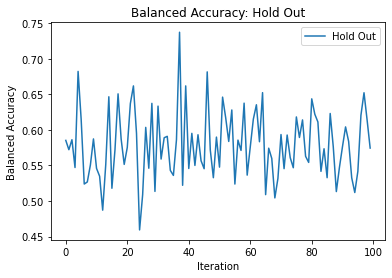

<IPython.core.display.Javascript object>

In [9]:
res = pd.DataFrame(knn_ho_ba, columns=["Hold Out"])
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out")

### 1.1.2 SMOTE Decision Tree

In [10]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3)
dt_ho_ba, dt_ho_acc = hold_out_resample(X, y, tree, smote)

========= Statistics for DecisionTreeClassifier =========
Mean Hold Out Accuracy: 0.72 
Mean Hold Out Balanced Accuracy: 0.61 
-------------------------------------------------------
Mean Hold Out f1-score Positive: 0.40 
Mean Hold Out f1-score Negative: 0.81 
-------------------------------------------------------
Mean Hold Out Precision Positive: 0.48 
Mean Hold Out Precision Negative: 0.85 
-------------------------------------------------------
Mean Hold Out Recall Positive: 0.37 
Mean Hold Out Recall Negative: 0.79 


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Balanced Accuracy: Hold Out')

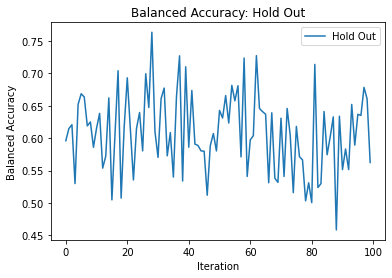

<IPython.core.display.Javascript object>

In [11]:
res = pd.DataFrame(dt_ho_ba, columns=["Hold Out"])
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out")

### 1.1.3 SMOTE Logistic Regression

In [12]:
logistic_reg = LogisticRegression(max_iter=4000)
lr_ho_ba, lr_ho_acc = hold_out_resample(X, y, logistic_reg, smote)

========= Statistics for LogisticRegression =========
Mean Hold Out Accuracy: 0.75 
Mean Hold Out Balanced Accuracy: 0.59 
-------------------------------------------------------
Mean Hold Out f1-score Positive: 0.33 
Mean Hold Out f1-score Negative: 0.84 
-------------------------------------------------------
Mean Hold Out Precision Positive: 0.58 
Mean Hold Out Precision Negative: 0.93 
-------------------------------------------------------
Mean Hold Out Recall Positive: 0.24 
Mean Hold Out Recall Negative: 0.77 


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Balanced Accuracy: Hold Out')

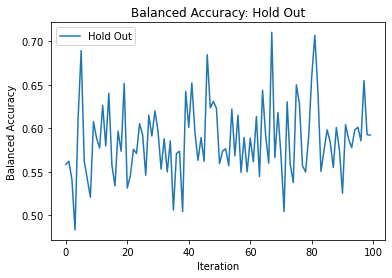

<IPython.core.display.Javascript object>

In [13]:
res = pd.DataFrame(lr_ho_ba, columns=["Hold Out"])
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out")

### 1.1.4 SMOTE Gradient Boosting

In [14]:
grad_boost = GradientBoostingClassifier(max_depth=5, n_estimators=10)
gb_ho_ba, gb_ho_acc = hold_out_resample(X, y, grad_boost, smote)

========= Statistics for GradientBoostingClassifier =========
Mean Hold Out Accuracy: 0.71 
Mean Hold Out Balanced Accuracy: 0.57 
-------------------------------------------------------
Mean Hold Out f1-score Positive: 0.32 
Mean Hold Out f1-score Negative: 0.81 
-------------------------------------------------------
Mean Hold Out Precision Positive: 0.43 
Mean Hold Out Precision Negative: 0.87 
-------------------------------------------------------
Mean Hold Out Recall Positive: 0.27 
Mean Hold Out Recall Negative: 0.77 


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Balanced Accuracy: Hold Out')

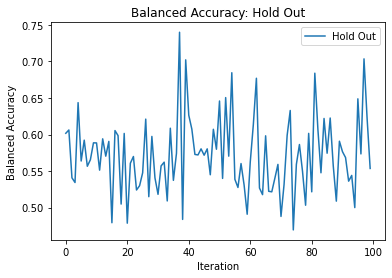

<IPython.core.display.Javascript object>

In [15]:
res = pd.DataFrame(gb_ho_ba, columns=["Hold Out"])
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out")

## 1.2 Pipelines and Cross Validation
In the Below section cross validation will be undertaken using a pipeline to sample the data using SMOTE. to ensure consistency with the Hold Out testing it will be run 100 times using 10 folds.

In [16]:
def cross_val(X, y, model, reps=100):
    xv_ba = []
    xv_acc = []

    pipe = Pipeline(steps=[("sampling", smote), ("classifier", model)])

    for i in range(reps):
        kf = KFold(n_splits=10, shuffle=True)
        scores = cross_val_score(
            pipe, X, y, cv=kf, scoring="balanced_accuracy", n_jobs=-1
        )
        xv_ba.append(scores.mean())

        acc = cross_val_score(pipe, X, y, cv=kf, scoring="accuracy", n_jobs=-1)
        xv_acc.append(acc.mean())

    print("Mean Cross validation Accuracy: %0.2f " % (sum(xv_acc) / reps))
    print("Mean Cross validation Balanced Accuracy: %0.2f " % (sum(xv_ba) / reps))

    return xv_acc, xv_ba

<IPython.core.display.Javascript object>

### 1.2.1 Cross Validation kNN

In [17]:
kNN_cv_acc, kNN_cv_ba = cross_val(X, y, kNN)

Mean Cross validation Accuracy: 0.68 
Mean Cross validation Balanced Accuracy: 0.58 


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Balanced Accuracy: Hold Out & Cross Validation')

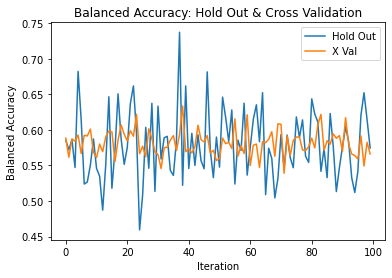

<IPython.core.display.Javascript object>

In [18]:
res = pd.DataFrame(knn_ho_ba, columns=["Hold Out"])
res["X Val"] = kNN_cv_ba
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out & Cross Validation")

When comparing the Hold Out test results for the rectifying strategy to those of the Cross validation results the  accuracy and balanced accuracy remain the same at 0.68 and 0.58 respectively.

when you observe the graph above it shows that Hold out has a much larger range of balanced accuracies compared with cross validation which appears to be a lot more stable. 

### 1.2.2 Cross Validation Decision Tree

In [19]:
dt_cv_acc, dt_cv_ba = cross_val(X, y, tree)

Mean Cross validation Accuracy: 0.71 
Mean Cross validation Balanced Accuracy: 0.62 


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Balanced Accuracy: Hold Out & Cross Validation')

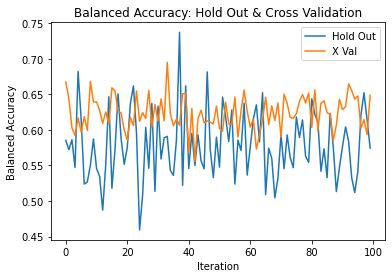

<IPython.core.display.Javascript object>

In [20]:
res = pd.DataFrame(knn_ho_ba, columns=["Hold Out"])
res["X Val"] = dt_cv_ba
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out & Cross Validation")

The accuracy of Cross validation falls slightly from 0.72 to 0.71 while balanced accuracy increases form 0.61 to 0.62.

when you observe the graph above it shows that Hold out has a much larger range of balanced accuracies compared with cross validation which appears to be a lot more stable. The majority of the Hold Out results are below the Cross validation line, with only a few peaks above the line.

### 1.2.3 Cross Validation Logistic Regression

In [21]:
lr_cv_acc, lr_cv_ba = cross_val(X, y, logistic_reg)

Mean Cross validation Accuracy: 0.75 
Mean Cross validation Balanced Accuracy: 0.59 


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Balanced Accuracy: Hold Out & Cross Validation')

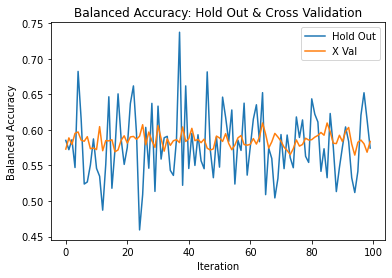

<IPython.core.display.Javascript object>

In [22]:
res = pd.DataFrame(knn_ho_ba, columns=["Hold Out"])
res["X Val"] = lr_cv_ba
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out & Cross Validation")

Accuracy remains the same as Hold Out at 0.78, while Balanced accuracy falls slightly from 0.59 to 0.58

when you observe the graph above it shows that Hold out has a much larger range of balanced accuracies compared with cross validation which appears to be a lot more stable. 

### 1.2.4 Cross Validation Gradient Boosting

In [23]:
gb_cv_acc, gb_cv_ba = cross_val(X, y, grad_boost)

Mean Cross validation Accuracy: 0.71 
Mean Cross validation Balanced Accuracy: 0.57 


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Balanced Accuracy: Hold Out & Cross Validation')

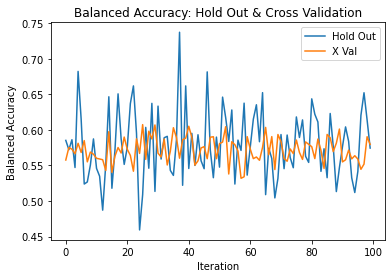

<IPython.core.display.Javascript object>

In [24]:
res = pd.DataFrame(knn_ho_ba, columns=["Hold Out"])
res["X Val"] = gb_cv_ba
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out & Cross Validation")

The accuracy and balanced accuracy remain the same as Hold Out at 0.72 and  0.57 respectively.

when you observe the graph above it shows that Hold out has a much larger range of balanced accuracies compared with cross validation which appears to be a lot more stable. The majority of the Hold Out results are above the Cross validation line.

## 1.2 Evaluation of Hold Out and Cross Validation

When comparing the two methods of implementing the rectifying strategy there appears to be very little between either Hold Out and Cross Validation.  

When looking at the individual graphs comparing Hold Out and Cross Validation, the cross-validation results appear to be much more stable unlike the Hold Out testing due to the random train test splitting. When choosing between the two methods Cross Validation may be a safer bet as although it does not achieve the same high accuracies, its stability ensures that it is more useable due to allowing for results to be more easily duplicated.It is prefferable over Hold Out as it allows for the classifier to train on numerous train test splits.

Hold Out testing on the otherhand may be a more suitable approach when dealing with large datasets as the computation time is shorter than that of cross Validation.


# Part 2

In [25]:
training = pd.read_csv("heart-train.csv")
testing = pd.read_csv("heart-test.csv")

<IPython.core.display.Javascript object>

In [26]:
training.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,60.0,0,253,0,35,0,279000.00,1.70,140,1,0,250,0
1,40.0,1,129,0,35,0,255000.00,0.90,137,1,0,209,0
2,86.0,0,582,0,38,0,263358.03,1.83,134,0,0,95,1
3,45.0,0,582,0,35,0,385000.00,1.00,145,1,0,61,1
4,72.0,0,127,1,50,1,218000.00,1.00,134,1,0,33,0
5,60.0,0,582,0,40,0,217000.00,3.70,134,1,0,96,1
6,61.0,1,84,0,40,1,229000.00,0.90,141,0,0,110,0
7,49.0,1,80,0,30,1,427000.00,1.00,138,0,0,12,0
8,45.0,0,582,0,20,1,126000.00,1.60,135,1,0,180,1
9,45.0,0,308,1,60,1,377000.00,1.00,136,1,0,186,0


<IPython.core.display.Javascript object>

In [27]:
# Instantiate Classifier
g_boost = GradientBoostingClassifier(max_depth=4, n_estimators=20, random_state=42)

<IPython.core.display.Javascript object>

When initial tests were conducted the stability of the results varied widely, due to no random state being set. This was evident from the accuracy of the gradient boosting changing slightly each time it was repeated. It also had a knock-on effect for the feature selection process as due to the stochastic nature of the data certain features achieved higher information gain and usefulness. This meant that the optimal number of features for prediction performance changed each time the feature selection process was executed. 
When the random state was set the resulting selected features did not vary to the same extent.


In [28]:
# Split the Training and Testing Data 
y_train = training.pop("DEATH_EVENT").values
X_train = training.values

y_test = testing.pop("DEATH_EVENT").values
X_test = testing.values


<IPython.core.display.Javascript object>

In [29]:
y_pred = g_boost.fit(X_train, y_train).predict(X_test)
print(X_train.shape, X_test.shape)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:  %0.2f" % accuracy)

bal_acc = balanced_accuracy_score(y_pred,y_test)
print("Balanced Accuracy:  %0.2f" % bal_acc)

confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion))

report = classification_report(y_test, y_pred, target_names = ['0','1'])
print("Report:\n{}".format(report)) 


(199, 12) (100, 12)
Accuracy:  0.86
Balanced Accuracy:  0.84
Confusion matrix:
[[61  7]
 [ 7 25]]
Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        68
           1       0.78      0.78      0.78        32

    accuracy                           0.86       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.86      0.86      0.86       100



<IPython.core.display.Javascript object>

- When using all of the features the gradient boosting classifier achieves a respectable accuracy score of 0.86, when tested  on the test data 

- The precision achieved for the majority class is higer than that of the negative class.

## Cross validation
Cross validation is performed below, which involves conducting a random train test split on the X_train and y_train data from "heart-train.csv"

In [30]:
def cross_val(X_train, y_train, model, reps=10):
    xv_ba = []
    xv_acc = []
    xv_f1 = []

    for i in range(reps):
        kf = KFold(n_splits=10, shuffle=True)
        scores = cross_val_score(
            model, X_train, y_train, cv=kf, scoring="balanced_accuracy", n_jobs=-1
        )
        xv_ba.append(scores.mean())

        ba = cross_val_score(model, X_train, y_train, cv=kf, scoring="accuracy")
        xv_acc.append(ba.mean())

        f1 = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1_macro")
        xv_f1.append(f1.mean())

    print("Mean Cross validation Accuracy: %0.2f " % (sum(xv_acc) / reps))
    print("Mean Cross validation Balanced Accuracy: %0.2f " % (sum(xv_ba) / reps))
    print("Mean Hold Out f1-score: %0.2f " % (sum(xv_f1) / reps))

<IPython.core.display.Javascript object>

In [31]:
cross_val(X_train, y_train, g_boost)

Mean Cross validation Accuracy: 0.79 
Mean Cross validation Balanced Accuracy: 0.73 
Mean Hold Out f1-score: 0.73 


<IPython.core.display.Javascript object>

The results of the above cross validation test are quite interesting as both the mean balanced accuracy and mean Cross validation accuracy are worse than when results for the test data.

## Hold Out Testing

In [32]:
def hold_out(X, y, X_test, y_test, model):
    reps = 10
    ho_ba = []
    ho_acc = []
    ho_f1 = []
    for i in range(reps):
        X_train, X_test_unused, y_train, y_test_unused = train_test_split(
            X, y, random_state=i
        )
        y_pred = model.fit(X_train, y_train).predict(X_test)

        # Obtain Balanced Accuracy
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        ho_ba.append(bal_acc)

        # Obtain Accuracy
        acc = accuracy_score(y_test, y_pred)
        ho_acc.append(acc)

        f1 = f1_score(y_test, y_pred, average="macro")
        ho_f1.append(f1)

    print("Mean Hold Out Accuracy: %0.2f " % (sum(ho_acc) / reps))
    print("Mean Hold Out Balanced Accuracy: %0.2f " % (sum(ho_ba) / reps))
    print("Mean Hold Out f1-score: %0.2f " % (sum(ho_f1) / reps))

<IPython.core.display.Javascript object>

In [33]:
hold_out(X_train, y_train, X_test, y_test, g_boost)

Mean Hold Out Accuracy: 0.82 
Mean Hold Out Balanced Accuracy: 0.76 
Mean Hold Out f1-score: 0.78 


<IPython.core.display.Javascript object>

### Analysis of test and train datasets

The results of the Hold Out test are more favourable than those achieved by Cross validation as they are trained using the trained data and tested using the test data. The results are slightly lower than when gradient boosting is used on its own.

Discrepancies are evident between the test and training datasets as the performance of both the Hold-Out test and the regular test fared considerably better than the Cross Validation which conducted testing only using the training data.


## Feature Subset Selection
In this section a subset of the features of the heart dataset will be selected. The method that will be used and analysed will be a wrapper.
A wrapper method evaluates the usefulness of a particular feature for a specific classifier based on performance
The reason why this method was favoured over the less computationally intensive filtering approach was due to only using a single classifier for this assessment. The wrapper method allows for classifier bias to be considers while also taking into account feature dependencies.

Two techniques for wrapper-based feature selection will be used in this assessment Forward Feature Selection and backward feature selection. The subsets from both methods will then be used to train the Gradient Boosting classifier and test using the subset of the testing data.

### Forward Feature Selection

In [34]:
feature_names = training.columns

sfs_forward = SFS(
    g_boost,
    k_features=X_train.shape[1],
    forward=True,
    floating=False,
    verbose=0,
    scoring="accuracy",
    cv=10,
    n_jobs=-1,
)

sfs_forward = sfs_forward.fit(
    X_train,
    y_train,
    custom_feature_names=feature_names,
)

<IPython.core.display.Javascript object>

In [35]:
forward_dict = sfs_forward.get_metric_dict()

maximum = 0
max_index = 0
for i in range(1, X_train.shape[1] + 1):
    accuracy = forward_dict[i]["avg_score"]
    if accuracy > maximum:
        maximum = accuracy
        max_index = i

    print("Accuracy:  %0.3f" % accuracy + ", features:", i)

print("=============================================")
print("Best Accuracy:  %0.3f" % maximum)

forward_features = list(forward_dict[max_index]["feature_names"])
print("Best Features", forward_features)

print("Best Feature", forward_dict[1]["feature_names"])

Accuracy:  0.830, features: 1
Accuracy:  0.835, features: 2
Accuracy:  0.829, features: 3
Accuracy:  0.829, features: 4
Accuracy:  0.834, features: 5
Accuracy:  0.829, features: 6
Accuracy:  0.834, features: 7
Accuracy:  0.834, features: 8
Accuracy:  0.834, features: 9
Accuracy:  0.789, features: 10
Accuracy:  0.784, features: 11
Accuracy:  0.739, features: 12
Best Accuracy:  0.835
Best Features ['high_blood_pressure', 'time']
Best Feature ('time',)


<IPython.core.display.Javascript object>

When observing the accuracies of each of the features above it is clear too see that the two features 'high_blood_pressure' and 'time' provide the subset of features with the best accuracies.

When observing the resulting accuracy there appears to be a lack of consistency as the accuracy appears as mountains and valleys. Whereas it would be expected that as the number of features increase so to would the accuracy until it reaches a plateau, but this is not the case.  as the accuracies rise and lower slightly consistently until they reach 9 features and then drop suddenly.  

### Select subset of features from Train and Test  Forward Feature Selection

In [36]:
X_train_forward = training[forward_features]

X_test_forward = testing[forward_features]


<IPython.core.display.Javascript object>

In [37]:
y_pred = g_boost.fit(X_train_forward, y_train).predict(X_test_forward)
print(X_train_forward.shape, X_test_forward.shape)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:  %0.2f" % accuracy)

bal_acc = balanced_accuracy_score(y_pred,y_test)
print("Balanced Accuracy:  %0.2f" % bal_acc)

confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion))

report = classification_report(y_test, y_pred, target_names = ['0','1'])
print("Report:\n{}".format(report)) 



(199, 2) (100, 2)
Accuracy:  0.87
Balanced Accuracy:  0.85
Confusion matrix:
[[62  6]
 [ 7 25]]
Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91        68
           1       0.81      0.78      0.79        32

    accuracy                           0.87       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.87      0.87      0.87       100



<IPython.core.display.Javascript object>

- When we compare the results of the feature selection test and the entire dataset test, there appears to be a minor improvement in terms of accuracy.

- This improvement is seen in the increase in The number of True Negative predictions and reduction in the False Positive predictions.

- The recall for the Negative class increases from 0.90 to 0.91

- The precision for the Positive class increase from 0.78 to 0.81

- When comparing the results to the Hold-Out test  the accuracy increases from 0.82 to 0.87

- Balanced Accuracy increases from 0.76 to 0.85

The same discrepancy that was observed in the Hold Out and Cross Validation test continues for the subset of the features with
the subset achieving and accuracy of  0.835  on the training data and 0.87 on the test data.


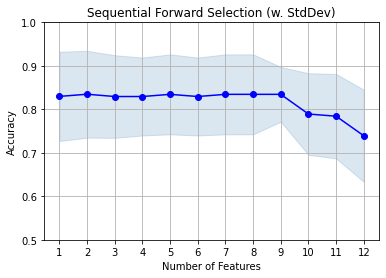

('age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time')


<IPython.core.display.Javascript object>

In [38]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_forward.get_metric_dict(), ylabel="Accuracy", kind="std_dev")

plt.ylim([0.5, 1])
plt.title("Sequential Forward Selection (w. StdDev)")
plt.grid()
plt.show()
print(sfs_forward.k_feature_names_)

The above graph shows that beyond the initial two features there is no real improvement from adding more features , which then comes to a point that the accuracy of the prediction falls due to the lare amount of information.

### Cross Validation Forward Feature Selection

In [39]:
cross_val(X_train_forward, y_train, g_boost)

Mean Cross validation Accuracy: 0.80 
Mean Cross validation Balanced Accuracy: 0.76 
Mean Hold Out f1-score: 0.75 


<IPython.core.display.Javascript object>

When comparing the Cross Validation of the full features compared with the subset of features an improvement is seen in all three metrics.

- Accuracy improves from 0.79 to 0.81

- Balanced Accuracy improves from 0.74 to 0.75

- f1-score improves from 0.73 to 0.76

### Hold-Out Forward Feature Selection

In [40]:
hold_out(X_train_forward, y_train, X_test_forward, y_test, g_boost)

Mean Hold Out Accuracy: 0.83 
Mean Hold Out Balanced Accuracy: 0.79 
Mean Hold Out f1-score: 0.80 


<IPython.core.display.Javascript object>

When comparing the Hold Out testing of the full features compared with the subset of features an improvement is seen in all three metrics.

- Accuracy improves from 0.82 to 0.83

- Balanced Accuracy improves from 0.76 to 0.79

- f1-score improves from 0.78 to 0.80

The improvement seen in both Hold Out and Cross Validation suggests that the features selected provide a stable improvement over using all 12 features.

### Backward Feature Selection

In [41]:
feature_names = training.columns

sfs_backward = SFS(
    g_boost,
    k_features=1,
    forward=False,
    floating=False,
    verbose=0,
    scoring="accuracy",
    cv=10,
    n_jobs=-1,
)

sfs_backward = sfs_backward.fit(
    X_train,
    y_train,
    custom_feature_names=feature_names,
)

<IPython.core.display.Javascript object>

In [42]:
backwards_dict = sfs_backward.get_metric_dict()

maximum = 0
max_index = 0
for i in range(1, X_train.shape[1] + 1):
    accuracy = backwards_dict[i]["avg_score"]
    if accuracy > maximum:
        maximum = accuracy
        max_index = i

    print("Accuracy:  %0.4f" % accuracy + ", features:", i)

print("=============================================")
print("Best Accuracy:  %0.3f" % maximum)

backward_features = list(backwards_dict[max_index]["feature_names"])
print("Best Features", backward_features)

print("Best Feature", backwards_dict[1]["feature_names"])

Accuracy:  0.8297, features: 1
Accuracy:  0.8345, features: 2
Accuracy:  0.8345, features: 3
Accuracy:  0.8295, features: 4
Accuracy:  0.8295, features: 5
Accuracy:  0.8295, features: 6
Accuracy:  0.8295, features: 7
Accuracy:  0.8345, features: 8
Accuracy:  0.8039, features: 9
Accuracy:  0.7945, features: 10
Accuracy:  0.7842, features: 11
Accuracy:  0.7392, features: 12
Best Accuracy:  0.834
Best Features ['platelets', 'time']
Best Feature ('time',)


<IPython.core.display.Javascript object>

Like the forward search before it the backwards search finds that the optimal number in terms of performance of features based on the training data is two, however 'high_blood_pressure' is replaced by 'platelets'.

### Select subset of features from Train and Test 

In [43]:
X_train_back = training[backward_features]
X_test_back = testing[backward_features]


<IPython.core.display.Javascript object>

In [44]:
y_pred = g_boost.fit(X_train_back, y_train).predict(X_test_back)
print(X_train_back.shape, X_test_back.shape)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:  %0.2f" % accuracy)

bal_acc = balanced_accuracy_score(y_pred,y_test)
print("Balanced Accuracy:  %0.2f" % bal_acc)

confusion = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{confusion}")

report = classification_report(y_test, y_pred, target_names = ['0','1'])
print("Report:\n{}".format(report)) 


(199, 2) (100, 2)
Accuracy:  0.85
Balanced Accuracy:  0.83
Confusion matrix:
[[61  7]
 [ 8 24]]
Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        68
           1       0.77      0.75      0.76        32

    accuracy                           0.85       100
   macro avg       0.83      0.82      0.83       100
weighted avg       0.85      0.85      0.85       100



<IPython.core.display.Javascript object>

- When we compare the results of the feature selection test and the entire dataset test, there appears to a fall in accuracy

- This fall is seen in the reduction in The number of True Positive predictions and the increase in the False Negative predictions.

- The recall for the Negative class reducess from 0.90 to 0.88

- The precision for the Positive class reducess from 0.78 to 0.77

- When comparing the results to the Hold-Out test  the accuracy increases from 0.82 to 0.85

- Balanced Accuracy increases from 0.76 to 0.83


The same discrepancy that was observed in the Hold Out and Cross Validation test continues for the subset of the features with
the subset achieving and accuracy of  0.83  on the training data and 0.85 on the test data.

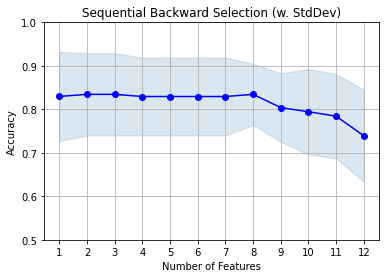

('time',)


<IPython.core.display.Javascript object>

In [45]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_backward.get_metric_dict(), ylabel="Accuracy", kind="std_dev")

plt.ylim([0.5, 1])
plt.title("Sequential Backward Selection (w. StdDev)")
plt.grid()
plt.show()
print(sfs_backward.k_feature_names_)

The graph above is similar to that of the Forward selection with a smoother fall in accuracy around 9 features.

### Cross Validation Backward Feature Selection

In [46]:
cross_val(X_train_back, y_train, g_boost)

Mean Cross validation Accuracy: 0.82 
Mean Cross validation Balanced Accuracy: 0.77 
Mean Hold Out f1-score: 0.77 


<IPython.core.display.Javascript object>

When comparing the Cross Validation of the full features compared with the subset of features an improvement is seen in all three metrics.

- Accuracy impoves from 0.79 to 0.81

- Balanced improves from at 0.74 to 0.76

- f1-score improves from 0.73 to 0.77

### Hold-Out Backward Feature Selection

In [47]:
hold_out(X_train_back, y_train, X_test_back, y_test, g_boost)

Mean Hold Out Accuracy: 0.79 
Mean Hold Out Balanced Accuracy: 0.74 
Mean Hold Out f1-score: 0.75 


<IPython.core.display.Javascript object>

When comparing the Hold Out testing of the full features compared with the subset of features a fall in perfomance is seen in all three metrics.

- Accuracy falls from 0.82 to 0.79

- Balanced Accuracy falls from 0.76 to 0.74 

- f1-score falls from 0.78 to 0.75

The subset of features achieves better results than when used with cross validation than the full data set , but this improvement does not carry through to the test data with a fall in performance when comparing the Hold Out testing using the subset of features.

 ## Evaluation of Feature Selection Methods

What is interesting about both methods is that the optimal number of features selected is two, however they are not the same features for both methods. It is worth noting that the feature that provides the most information for both methods is 'time'.

For this dataset the Forward Feature Method appears to be the most suitable approach as it improves the overall accuracy, precision and recall for the classifier.


When more features are used for predicting the accuracy appears to plateau and then eventually drop off. 
The heuristic nature of the backwards and forward Selection may play into the fact that the optimal features may have not been selected.

## Filter-based Feature Selection using Information Gain
Information gain refers to the reduction of entropy calculated foe a given dataset. By maximising the information gain it allows the data to be split  into the most optimal datasets, thus reducing the entropy of the dataset, which in turn leads to a good quality classification.

The filter-based feature selection of the dataset obtains the individual information gain associated with each of the features. The Information gain values will be used to rank the features based on the level of improvement to entropy. This method is useful for finding those features that will likely aid in the prediction process and those that may hinder it. The one drawback to this process is that it is classifier exclusive, so does not consider the individual classifiers biases towards certain features(Brownlee, 2019).





In [48]:
mi = dict()

i_scores = mutual_info_classif(X_train, y_train, random_state=42)

for i, j in zip(training.columns, i_scores):
    mi[i] = j

df = pd.DataFrame.from_dict(mi, orient="index", columns=["I-Gain"])
df.sort_values(by=["I-Gain"], ascending=False, inplace=True)
df.head(12)

,I-Gain
time,0.219685
ejection_fraction,0.124370
serum_creatinine,0.094409
age,0.073793
high_blood_pressure,0.015798
serum_sodium,0.006881
anaemia,0.000000
creatinine_phosphokinase,0.000000
diabetes,0.000000
platelets,0.000000


<IPython.core.display.Javascript object>

When looking at the information gain table above it is clear that the information provided by **time** is highly significant as it is nearly two times the value of the next highest feature **serum_creatinine**. Time was also the most useful feature for both Forward and Backwards Feature selection.

Four of the features provide no information, of these features  **platelets** is chosen by Backwards Feature selection as well as the **time** feature as part of the best features subset.

In [49]:
# retrieve the feature names in reverse order depending on infrmation gain
i_gain = [x[1] for x in sorted([(v, k) for (k, v) in mi.items()], reverse=True)]

<IPython.core.display.Javascript object>

In [50]:
# train_ig test_ig split to
X_train_ig, X_test_ig, y_train_ig, y_test_ig = train_test_split(
    X_train, y_train, random_state=42
)

acc_scores = []
for kk in range(1, X_train.shape[1] + 1):
    FS_trans = SelectKBest(mutual_info_classif, k=kk).fit(X_train_ig, y_train_ig)
    X_tR_new = FS_trans.transform(X_train_ig)
    X_tS_new = FS_trans.transform(X_test_ig)
    seg_NB = g_boost.fit(X_tR_new, y_train_ig)
    y_dash = seg_NB.predict(X_tS_new)
    acc = accuracy_score(y_test_ig, y_dash)
    acc_scores.append(acc)

df["Accuracy"] = acc_scores
df.head(10)

,I-Gain,Accuracy
time,0.219685,0.84
ejection_fraction,0.124370,0.86
serum_creatinine,0.094409,0.78
age,0.073793,0.82
high_blood_pressure,0.015798,0.74
serum_sodium,0.006881,0.80
anaemia,0.000000,0.82
creatinine_phosphokinase,0.000000,0.78
diabetes,0.000000,0.76
platelets,0.000000,0.78


<IPython.core.display.Javascript object>

In [51]:
X_train_features = training[["time", "ejection_fraction"]]
X_test_features = testing[["time", "ejection_fraction"]]
y_pred = g_boost.fit(X_train_features, y_train).predict(X_test_features)

acc = accuracy_score(y_pred, y_test)
print(acc)

0.87


<IPython.core.display.Javascript object>

In [52]:
# Obtain the accuracies achived when adding each feature
train = []
accuracies = []
best = 0
best_idx = 0


for i, feature in enumerate(i_gain):
    train.append(feature)

    X_tr_ig = training[train]

    X_train_ig, X_test_ig, y_train_ig, y_test_ig = train_test_split(
        X_tr_ig, y_train, random_state=42
    )

    y_pred = g_boost.fit(X_train_ig, y_train_ig).predict(X_test_ig)
    ig_acc = accuracy_score(y_pred, y_test_ig)
    accuracies.append(ig_acc)
    print(f"Features: {i+1}, {ig_acc}")

    if ig_acc >= best:
        best = ig_acc
        best_idx = i + 1


best_features = train[:best_idx]

Features: 1, 0.84
Features: 2, 0.92
Features: 3, 0.78
Features: 4, 0.8
Features: 5, 0.82
Features: 6, 0.8
Features: 7, 0.8
Features: 8, 0.78
Features: 9, 0.82
Features: 10, 0.78
Features: 11, 0.8
Features: 12, 0.78


<IPython.core.display.Javascript object>

The above results show that there is stability due to the random state for the mutual info classifier and gradient boost being set.

In [53]:
# # display the best features obtained using Information gain
best_features

['time', 'ejection_fraction']

<IPython.core.display.Javascript object>

Of the 12 features in the training dataset two features provided the best accuracy are 'time' and 'ejection_fraction'.

c:\users\sed\anaconda3\envs\comp47750\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


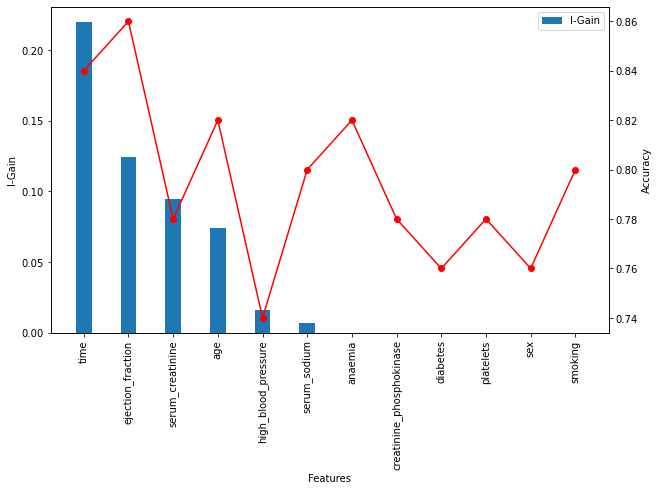

<IPython.core.display.Javascript object>

In [54]:
%matplotlib inline

n = len(df.index)
rr = range(1, n)
fig, ax = plt.subplots(figsize=(10, 6))

ax2 = ax.twinx()
ax.bar(df.index, df["I-Gain"], label="I-Gain", width=0.35)
ax2.plot(df.index, df["Accuracy"], "-o", color="red", label="Accuracy")
ax.set_xticklabels(list(df.index), rotation=90)
ax.set_xlabel("Features")
ax.set_ylabel("I-Gain")
ax2.set_ylabel("Accuracy")
ax.legend()
plt.show()

The graph above shows that after adding 'ejection-fraction' the perfomance typically falls when adding new features until it reaches 'sex' where the perfomance increases. 

### Applying the best features subset on test data

In [55]:

# Select only the best features from train and test
X_train_ig = training[best_features]
X_test_ig = testing[best_features]
    

y_pred = g_boost.fit(X_train_ig , y_train).predict(X_test_ig)
print(X_train_ig .shape, X_test_ig.shape)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:  %0.2f" % accuracy)

bal_acc = balanced_accuracy_score(y_pred,y_test)
print("Balanced Accuracy:  %0.2f" % bal_acc)


confusion = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{confusion}")

report = classification_report(y_test, y_pred, target_names = ['0','1'])
print("Report:\n{}".format(report)) 


(199, 2) (100, 2)
Accuracy:  0.87
Balanced Accuracy:  0.86
Confusion matrix:
[[63  5]
 [ 8 24]]
Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        68
           1       0.83      0.75      0.79        32

    accuracy                           0.87       100
   macro avg       0.86      0.84      0.85       100
weighted avg       0.87      0.87      0.87       100



<IPython.core.display.Javascript object>

When comparing the results to those of the gradient boosting using the full 12 features there is a small improvement in terms of accuracy. 

- There is a noteable improvement to the precision of the minority class from 0.78 to .93

- An improvement in in the recall of the majority class can be seen with an increase from 0.90 to 0.97

- An improvement in the f1-score of the majority class can be seen with an increase from 0.90 to 0.94

- An improvement in the f1-score of the majority class can be seen with an increase from 0.78 to 0.85

- When comparing the results to the Hold-Out test  the accuracy increases from 0.82 to 0.87

- Balanced Accuracy increases from 0.76 to 0.86


The discrepancy that was observed in the Hold Out/Cross Validation and Sequential search was not evident in the filter based selection as the two features that provided the highest accuracy for the test data at 0.92 did not perform as well when applied to the test data only achieving an accuracy of 0.87.

### Cross Validation Filter-based Feature Selection

In [56]:
cross_val(X_train_ig, y_train, g_boost)

Mean Cross validation Accuracy: 0.80 
Mean Cross validation Balanced Accuracy: 0.75 
Mean Hold Out f1-score: 0.74 


<IPython.core.display.Javascript object>

- Mean Cross validation Accuracy improves from 0.79 to 0.80 
- Mean Cross validation Balanced improves from 0.73 to 0.75 
- Mean Hold Out f1-score improves from 0.72 to 0.74 

### Hold-Out Filter-based Feature Selection

In [57]:
hold_out(X_train_ig, y_train, X_test_ig, y_test, g_boost)

Mean Hold Out Accuracy: 0.83 
Mean Hold Out Balanced Accuracy: 0.79 
Mean Hold Out f1-score: 0.80 


<IPython.core.display.Javascript object>

- Mean Hold Out Accuracy improves from 0.82 to  0.83 
- Mean Hold Out Balanced Accuracyimproves from 0.76 to  0.79 
- Mean Hold Out f1-score improves from 0.78 to 0.80 

### Combining results from Different Feature Selection methods
A further test will be conducted to assess whether combining the features from the three feature selection methods may result in a better overall performance than the individual selection subsets.

In [58]:
# Set the best features as the union of all subsets
best_features = [
    "time",
    "ejection_fraction",
    "high_blood_pressure",
    "platelets",
]

<IPython.core.display.Javascript object>

In [59]:
# Select only the best features from train and test
X_train_ig = training[best_features]
X_test_ig = testing[best_features]
    

y_pred = g_boost.fit(X_train_ig , y_train).predict(X_test_ig)
print(X_train_ig .shape, X_test_ig.shape)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy:  %0.2f" % accuracy)

bal_acc = balanced_accuracy_score(y_pred,y_test)
print("Balanced Accuracy:  %0.2f" % bal_acc)

confusion = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{confusion}")

report = classification_report(y_test, y_pred, target_names = ['0','1'])
print("Report:\n{}".format(report)) 


(199, 4) (100, 4)
Accuracy:  0.85
Balanced Accuracy:  0.84
Confusion matrix:
[[63  5]
 [10 22]]
Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        68
           1       0.81      0.69      0.75        32

    accuracy                           0.85       100
   macro avg       0.84      0.81      0.82       100
weighted avg       0.85      0.85      0.85       100



<IPython.core.display.Javascript object>

When combining the best features from both methods of feature selection the results were worse than the information gain results and similar to using all 12 feratures.

The accuracy remained the same as using all 12 features

- When comparing the results to the Hold-Out test  the accuracy increases from 0.82 to 0.86

- Balanced Accuracy increases from 0.76 to 0.84

### Testing Individual Features

In [60]:
# Obtain the accuracies achived when adding each feature
train = []
test = []
accuracies = []


for i, feature in enumerate(i_gain):
    X_tr_ind = training[[feature]]
    
    X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(
        X_tr_ind, y_train, random_state=42
    )

    y_pred = g_boost.fit(X_train_ind, y_train_ind).predict(X_test_ind)
    ig_acc = accuracy_score(y_pred, y_test_ind)
    accuracies.append(ig_acc)
    
    print(f"Feature: {feature}, Accuracy: {ig_acc}")

  



Feature: time, Accuracy: 0.84
Feature: ejection_fraction, Accuracy: 0.62
Feature: serum_creatinine, Accuracy: 0.7
Feature: age, Accuracy: 0.72
Feature: high_blood_pressure, Accuracy: 0.66
Feature: serum_sodium, Accuracy: 0.6
Feature: smoking, Accuracy: 0.66
Feature: sex, Accuracy: 0.66
Feature: platelets, Accuracy: 0.56
Feature: diabetes, Accuracy: 0.66
Feature: creatinine_phosphokinase, Accuracy: 0.66
Feature: anaemia, Accuracy: 0.66


<IPython.core.display.Javascript object>

In [61]:
df["Accuracy"] = accuracies
df

,I-Gain,Accuracy
time,0.219685,0.84
ejection_fraction,0.124370,0.62
serum_creatinine,0.094409,0.70
age,0.073793,0.72
high_blood_pressure,0.015798,0.66
serum_sodium,0.006881,0.60
anaemia,0.000000,0.66
creatinine_phosphokinase,0.000000,0.66
diabetes,0.000000,0.56
platelets,0.000000,0.66


<IPython.core.display.Javascript object>

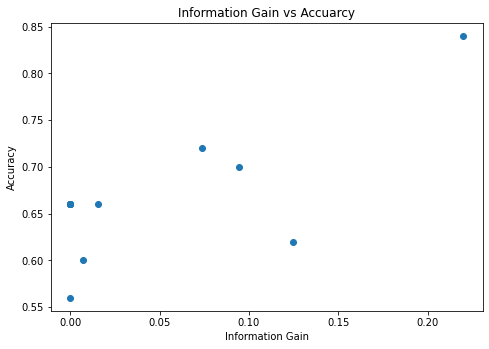

<IPython.core.display.Javascript object>

In [62]:
i_gain_scores = df["I-Gain"].values
accuracy_scores = df["Accuracy"].values

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(
    i_gain_scores,
    accuracy_scores,
)
ax.set_xlabel("Information Gain")
ax.set_ylabel("Accuracy")
ax.set_title("Information Gain vs Accuarcy")
plt.show()

In [63]:
from scipy.stats import pearsonr

corr, _ = pearsonr(i_gain_scores, accuracy_scores)
print("Correlation between Information Gain & Accuracy: %.3f" % corr)

Correlation between Information Gain & Accuracy: 0.727


<IPython.core.display.Javascript object>

### Analysis Information Gain and Accuracy
The high correlation between information gain and accuracy suggests that information gain is a useful measure for predicting the accuracies achievable for specific features.

when looking at the accuracy and information gain table above there are a few anomalies where the high information gain does not match up with the accuracies. This is more evident in the below table sorted by accuracy, where **ejection_fraction** has quite a high information gain value but results in a poor accuracy. The opposite is the case for **diabetes,creatinine_phosphokinase,platelets** and **sex** which all have information gain of 0 but an accuracy of 66% which is better than **ejection_fraction** at 62%.

When looking at both tables the **time** feature is consistently the single feature that provides the highest information gain and accuracy, it was also chosen by both forward and backwards subset selection as the most useful feature. The other features struggle to provide the same level of information gain and Accuracy as **time** does.

In [64]:
df = df.sort_values(by="Accuracy", ascending=False)
df

,I-Gain,Accuracy
time,0.219685,0.84
age,0.073793,0.72
serum_creatinine,0.094409,0.70
high_blood_pressure,0.015798,0.66
anaemia,0.000000,0.66
creatinine_phosphokinase,0.000000,0.66
platelets,0.000000,0.66
sex,0.000000,0.66
smoking,0.000000,0.66
ejection_fraction,0.124370,0.62


<IPython.core.display.Javascript object>

In [65]:
accuracy_features = [key for key, value in df.Accuracy.items()]

<IPython.core.display.Javascript object>

In [66]:
# Obtain the accuracies achived when adding each feature
train = []
test = []
accuracies = []

best = 0
best_idx = 0

for i, feature in enumerate(accuracy_features):
    train.append(feature)

    X_tr_mul = training[train]

    X_train_mul, X_test_mul, y_train_mul, y_test_mul = train_test_split(
        X_tr_mul, y_train, random_state=42
    )

    y_pred = g_boost.fit(X_train_mul, y_train_mul).predict(X_test_mul)
    ig_acc = accuracy_score(y_pred, y_test_mul)
    accuracies.append(ig_acc)

    print(f"Features: {i+1}, Accuracy: {ig_acc}")

    if ig_acc > best:
        best = ig_acc
        best_idx = i + 1


best_features = train[:best_idx]
print(best_features)

Features: 1, Accuracy: 0.84
Features: 2, Accuracy: 0.8
Features: 3, Accuracy: 0.84
Features: 4, Accuracy: 0.8
Features: 5, Accuracy: 0.82
Features: 6, Accuracy: 0.84
Features: 7, Accuracy: 0.82
Features: 8, Accuracy: 0.84
Features: 9, Accuracy: 0.84
Features: 10, Accuracy: 0.78
Features: 11, Accuracy: 0.76
Features: 12, Accuracy: 0.76
['time']


<IPython.core.display.Javascript object>

The feature subset that performs the best is the same as the mutual info classifier selecting both 'time' and 'ejection_fraction'.


## Analysis of Feature Subset Selection
- When comparing the performances of all the best subset selections for each of the methods Information gain  and Forward selection come out on top.

- Backwards feature selection led to a fall in accuracy.


- By simply testing individual features in terms of accuracy then adding new features based on accuracy, it provided an improvement over the gradient boosting prediction using all 12 features.


- The classifier bias for certain features did not hinder the outcome for the information gain method as even though some features had high information gain and poorer individual accuracies, when combined into a subset of features it resulted in a small improvement in terms of performance.


- All three of the feature slection methods provided subsets of features that achieved marginally better results than the Hold-Out method did on all 12 features.


- The Cross-validation results were typically better for the subset of features than for all 12 features.


- The Hold Out results barring backwards selection were better for the subset than for all 12 features.


What is most interesting is that all three methods chose two features as the optimal size but differed in the selection of the second most important feature. The size showed a consistency in feature selection and the selection  of **time** also.

When comparing the information gain with accuracy it is worth noting that the two are not perfectly correlated with a few features having high information gain and low accuracy and vice versa.

One factor that was consistent throughout the selection process was the fall in performance after a certain point as the number of features increased. However, this fall can be attributed to the features themselves and not just the number of features as such the number of features at which a fall was evident differed between the three selection methods.

By setting the random state for both the gradient boosting model and the mutual info classifier it ensures that there was a stability and repeatability to the results.


When using the **time** feature on its own to train the model it provided perfomance that was just slighlty lower than uisng all 12  features. This provides an insight into the usefullness of the data collected as it consistently outperfomred the other features in terms of usefullnes,information gain and accuracy. When combining the other featuires they only atrribute to a very small increase in performance. This may suggest that there could be other features that could have been collected that provide more information for the prediction process.

One issue arose over the stability of the results when using the Hold Out and Cross Validation methods as when the entire notebook was rerun different metrics were produced that varied marginally. This occurred even after setting the random state to a set integer value.


The discrepancies in performance between the train and test data were evident from the results of the Hold Out/Cross Validation, Sequential search and filter based feature selection methods. For the most part the testing data resulted in higher accuracies than the train data barring the filter based selection methods. It is quite possible that there is an alternative subset of features that would perform much better on the test data but would generalise poorly to a different set of data.

Some of the features may play a bigger role in deciding the outcome of the test data than in the training data.

Brownlee, J. (2019). Information Gain and Mutual Information for Machine Learning. [online]
Machine Learning Mastery.
Available at: https://machinelearningmastery.com/information-gain-and-mutual-information/